In [5]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn import metrics, linear_model
from sklearn.neural_network import BernoulliRBM
from sklearn.model_selection import train_test_split, cross_val_score
from skimage import color

%matplotlib inline

In [2]:
#Function for loading data files, taken from http://www.cs.utoronto.ca/~kriz/cifar.html

#RBM example here: http://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

directory = 'C:\\Users\\ryan\\Desktop\\Thinkful DS Sample Data - Main Course\\Unit 4\\Images RBM V2\\cifar-10-batches-py\\'
batch = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']

In [6]:
#Explore the dict that is returned by unpickling
data1 = unpickle(directory+'data_batch_1')
data2 = unpickle(directory+'data_batch_2')
data3 = unpickle(directory+'data_batch_3')
data4 = unpickle(directory+'data_batch_4')
data5 = unpickle(directory+'data_batch_5')

In [28]:
#Pixel data stored in b'data 
pix1 = data1.get(b'data')
pix2 = data2.get(b'data')
pix3 = data3.get(b'data')
pix4 = data4.get(b'data')
pix5 = data5.get(b'data')

#Labels stored in b'labels
lab1 = data1.get(b'labels')
lab2 = data2.get(b'labels')
lab3 = data3.get(b'labels')
lab4 = data4.get(b'labels')
lab5 = data5.get(b'labels')

pix1.shape

(10000, 3072)

In [29]:
#In each batch, there are 10K images. They are collapsed 32 x 32 x 3 (32 pixels x 32 pixels x RBG dimensions) = 3072.
#Want to convert them back to 3 dimensions so that I can average the RBG values for a conversion to black/white

pix = np.concatenate((pix1, pix2, pix3, pix4, pix5))
labels = np.concatenate((lab1, lab2, lab3, lab4, lab5))

In [30]:
#Reshape to RBG for black/white conversion
reshaped_pix = []
for img in pix:
    reshaped_pix.append(np.reshape(img, (32, 32, 3), order = 'F'))

In [31]:
#Convert to black/white as well. Weighted rather than simple average due to way humans perceive color
def black_white_conv(pixel):
    return pixel[0]*0.2125 + pixel[1]*0.7154 + pixel[2]*0.0721

converted = []
for img in range(len(reshaped_pix)):
    for row in range(len(reshaped_pix[img])):
        for col in range(len(reshaped_pix[img][row])):
            converted.append(black_white_conv(reshaped_pix[img][row][col]))

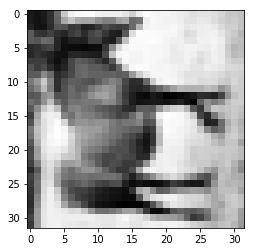

In [32]:
#Resize for plotting and model training purposes
converted_v2 = np.reshape(converted, (len(pix), int(len(pix[0])/3)))

#Example of horse image after converted to black/white
plt.imshow(np.reshape(converted_v2[7], (32 , 32)), cmap = matplotlib.cm.Greys_r)

In [33]:
#Final Dataset
print('Number of observations:', len(converted_v2))
print('Number of features:', len(converted_v2[0]))

Number of observations: 50000
Number of features: 1024


In [ ]:
#Lookup values

#integer            label

#   0 -          airplane
#   1 -        automobile
#   2 -              bird
#   3 -               cat
#   4 -              deer
#   5 -               dog
#   6 -              frog
#   7 -             horse
#   8 -              ship
#   9 -             truck

[BernoulliRBM] Iteration 1, pseudo-likelihood = -637.52, time = 56.47s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -637.22, time = 75.24s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -642.14, time = 82.01s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -652.57, time = 67.43s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -646.14, time = 59.14s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -627.79, time = 59.68s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -634.98, time = 98.71s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -634.78, time = 78.81s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -615.82, time = 79.47s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -630.80, time = 84.18s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -612.01, time = 80.85s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -624.07, time = 73.29s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -612.57, time = 64.60s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -612.63, time = 71.87s
[

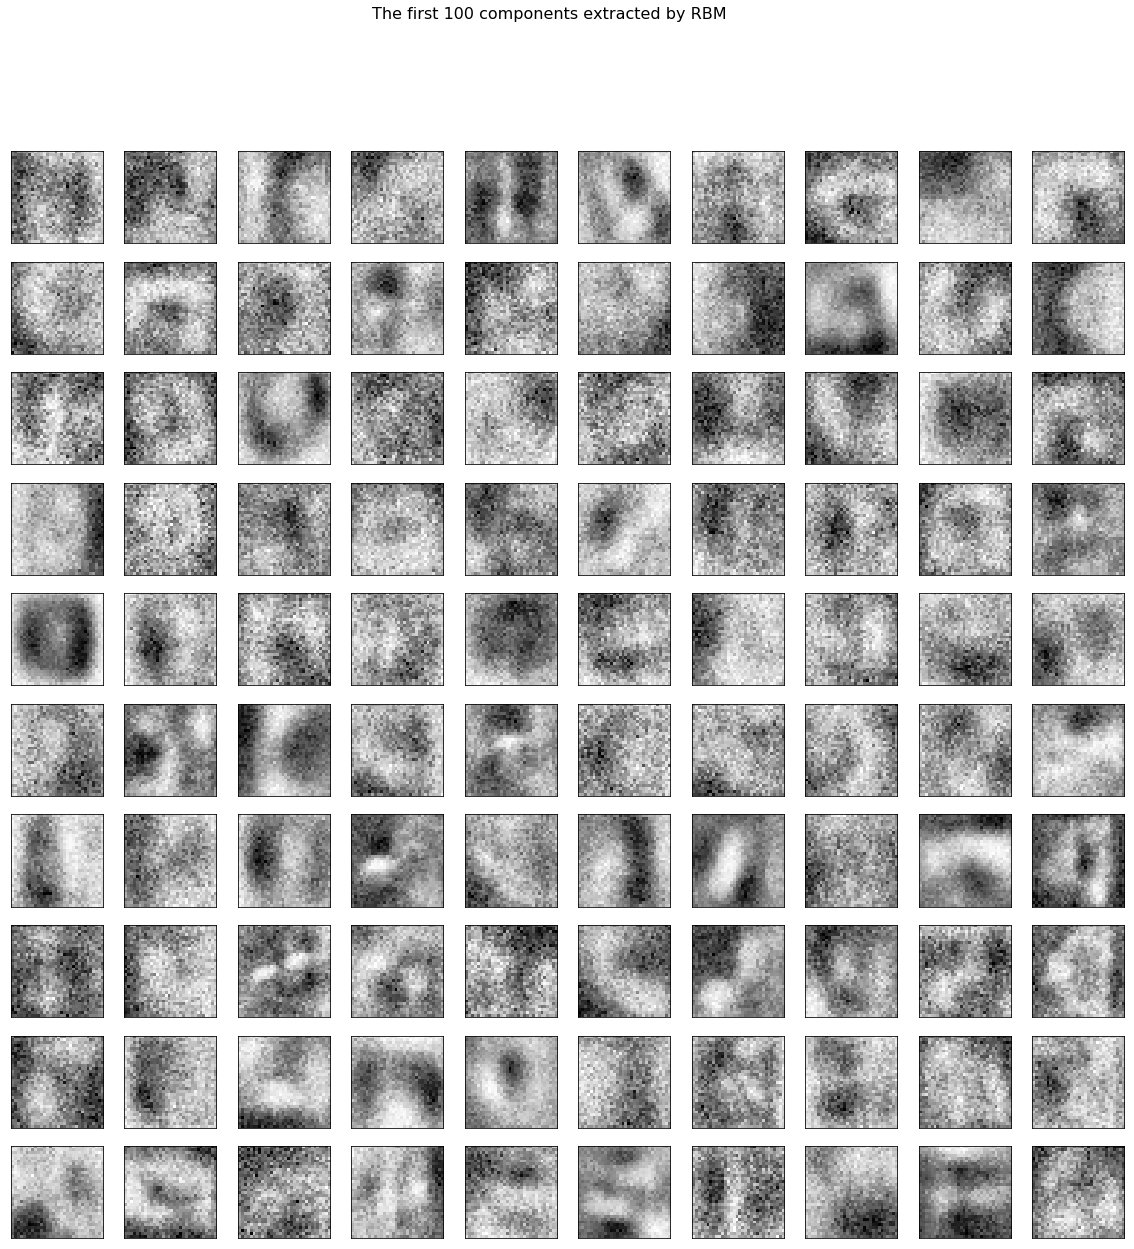

In [34]:
#Construct RBM+Logistic regression model. RBM features will be used as inputs for logistic regression.

#First, scale all features from 0-1, as the BernoulliRBM model expects feature values to be in this range.
converted_v3 = (converted_v2 - np.min(converted_v2, 0)) / (np.max(converted_v2, 0) + 0.0001) 

#Next, split the data into train and test sets for model building and validation
X_train, X_test, y_train, y_test = train_test_split(converted_v3, labels, test_size = 0.3)

# Models we will use
from sklearn import linear_model

#Starting values borrowed from the RBM example: 
#http://scikit-learn.org/stable/auto_examples/neural_networks/plot_rbm_logistic_classification.html

logistic = linear_model.LogisticRegression()
rbm = BernoulliRBM(random_state=0, verbose=True, n_iter = 20, n_components = 500, learning_rate = 0.06)
classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

logistic.C = 6000.0
#logistic.class_weight = 'balanced'

# Training RBM-Logistic Pipeline
classifier.fit(X_train, y_train)

# Training Logistic regression
logistic_classifier = linear_model.LogisticRegression(C=100.0)
logistic_classifier.fit(X_train, y_train)

#Compare RBM+Logistic to just Logistic model
print()
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(
        y_test,
        classifier.predict(X_test))))

print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(
        y_test,
        logistic_classifier.predict(X_test))))

#Visualize the components
plt.figure(figsize=(20, 20))
for i in range (0,100):
    comp = rbm.components_[i]
    plt.subplot(10, 10, i + 1)
    img = np.reshape(comp,(32, 32))
    plt.imshow(img, cmap = matplotlib.cm.Greys_r, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('The first 100 components extracted by RBM', fontsize=16)

plt.show()

In [ ]:
#Try a grid-search optimization for the RBM-Logistic model...can we make it any better?
#Takes too long to run... but keep this code for future reference

#Find Best RBM Parameters

from sklearn import neural_network
from sklearn import ensemble
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV

# Split the dataset 
X_train, X_test, y_train, y_test = train_test_split(converted_v3, labels, test_size = 0.3)

rbm = BernoulliRBM()
logistic = linear_model.LogisticRegression()

classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

#Double under-bars to specify which part of the pipeline the parameters belong to
tuned_parameters = [{'rbm__learning_rate': [0.0001, 0.001, 0.01],
                     'rbm__n_iter': [20, 30],
                     'rbm__n_components': [100,200],
                     'logistic__class_weight': ['balanced', None],
                    'logistic__C': [0.1, 1, 10, 100, 1000, 10000],
                    'logistic__dual': [True, False],
                    'logistic__max_iter': [500]
                    }]
 
gscv = GridSearchCV(classifier, param_grid = tuned_parameters, cv = 3, n_jobs = -1)
gscv.fit(X_train, y_train)
gscv.best_estimator_